# DiffVax Immunization Demo

This notebook demonstrates **DiffVax**: immunization against diffusion-based edits.

We compare:
- **Original image** → edit with a text prompt → **Edited (original)**
- **Immunized image** (DiffVax) → same edit → **Edited (immunized)**

When immunization works, the edited immunized image resists the requested change in the masked region (e.g. the face stays intact), while the edited original follows the prompt.

## Setup

In [ ]:
import os
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

from diffvax.attack import Attack
from diffvax.immunization import DiffVaxImmunization
from diffvax.utils import (
    set_seed_lib,
    load_image_from_path,
    prepare_mask_and_masked_image,
    recover_image,
)

to_pil = T.ToPILImage()

## Configuration

In [6]:
# Paths (relative to project root)
IMAGE_PATH = os.path.join(project_root, "data", "validation", "images", "image_1.png")
MASK_PATH = os.path.join(project_root, "data", "validation", "masks", "mask_image_1.png")
CHECKPOINT_PATH = os.path.join(project_root, "checkpoints", "diffvax_trained.pth")

# Edit prompt used for comparison
EDIT_PROMPT = "a person in an alley"

# Reproducibility
SEED = 5

# Diffusion model (must match the one used for training the checkpoint)
ATTACK_MODEL = "runwayml/stable-diffusion-inpainting"

## Load models

In [7]:
print("Loading diffusion model and immunization checkpoint...")
attack_model = Attack(ATTACK_MODEL)
immunization_mdl = DiffVaxImmunization(
    attack_model,
    config={"learning_rate": 3.0},
    load_existing=True,
    load_path=CHECKPOINT_PATH,
)
print("Done.")

vae/diffusion_pytorch_model.safetensors not found


Loading diffusion model and immunization checkpoint...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Done.


## Load image and mask

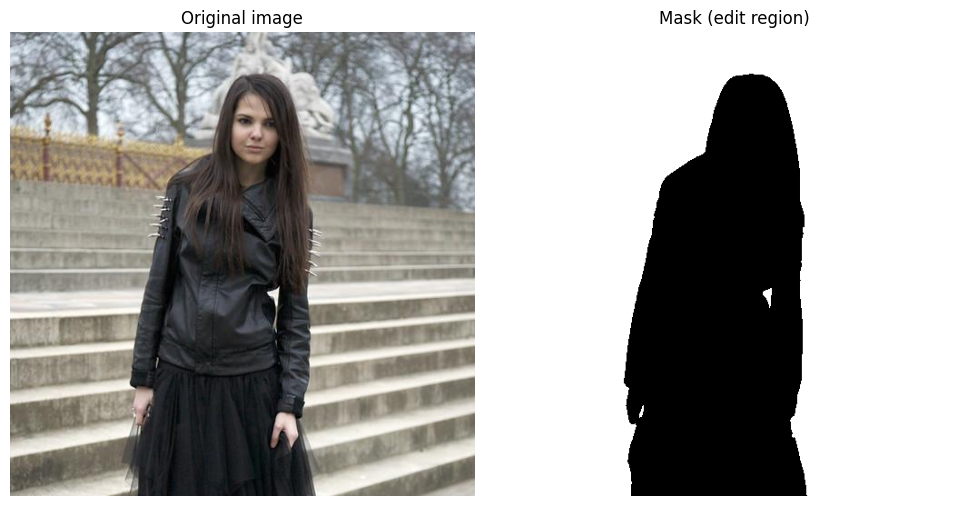

In [8]:
image = load_image_from_path(IMAGE_PATH)
image_mask = load_image_from_path(MASK_PATH)

mask_torch, image_torch, _ = prepare_mask_and_masked_image(image, image_mask)
image_torch = image_torch.half().cuda()
mask_torch = mask_torch.half().cuda()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original image")
ax[0].axis("off")
ax[1].imshow(image_mask)
ax[1].set_title("Mask (edit region)")
ax[1].axis("off")
plt.tight_layout()
plt.show()

## Apply immunization and run edits

In [9]:
set_seed_lib(SEED)

# Immunize the image
immunized_img, _ = immunization_mdl.immunize_img(image_torch, mask_torch)
adv_X = (immunized_img / 2 + 0.5).clamp(0, 1)
adv_image_png = to_pil(adv_X[0]).convert("RGB")
adv_image_png = recover_image(adv_image_png, image, image_mask, background=True)

# Edit original image with the prompt
edited_orig = immunization_mdl.edit_image(EDIT_PROMPT, image, image_mask)[0]
edited_orig_recovered = recover_image(edited_orig, image, image_mask, background=False)

# Edit immunized image with the same prompt
edited_adv = immunization_mdl.edit_image(EDIT_PROMPT, adv_image_png, image_mask)[0]
edited_adv_recovered = recover_image(edited_adv, adv_image_png, image_mask, background=False)

print("Immunization and edits completed.")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Immunization and edits completed.


## Compare: Original vs immunized edit

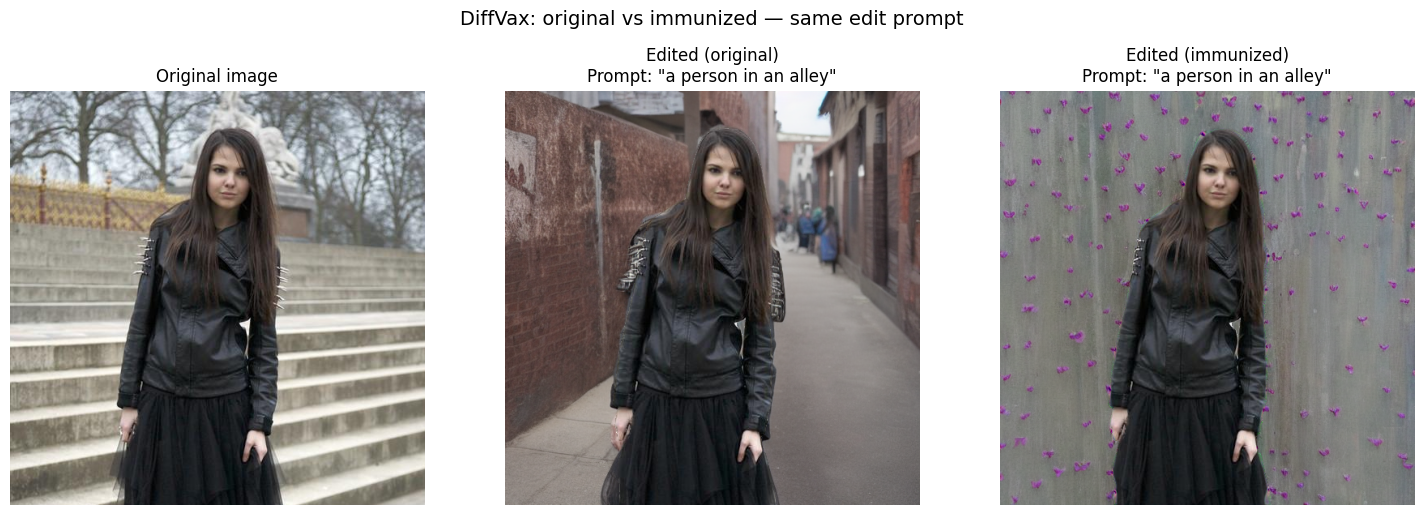

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title("Original image", fontsize=12)
axes[0].axis("off")

axes[1].imshow(edited_orig_recovered)
axes[1].set_title(f"Edited (original)\nPrompt: \"{EDIT_PROMPT}\"", fontsize=12)
axes[1].axis("off")

axes[2].imshow(edited_adv_recovered)
axes[2].set_title(f"Edited (immunized)\nPrompt: \"{EDIT_PROMPT}\"", fontsize=12)
axes[2].axis("off")

plt.suptitle("DiffVax: original vs immunized — same edit prompt", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Interpretation:** The **edited (original)** image follows the prompt in the masked region. The **edited (immunized)** image should resist that change (e.g. the face or masked region stays closer to the immunized content), showing that DiffVax protects the region from the diffusion edit.

In [12]:
OUTPUT_DIR = os.path.join(project_root, "outputs", "diffvax_demo")
os.makedirs(OUTPUT_DIR, exist_ok=True)

image_name = os.path.splitext(os.path.basename(IMAGE_PATH))[0]
adv_image_png.save(os.path.join(OUTPUT_DIR, f"{image_name}_diffvax_adv.png"))
edited_orig_recovered.save(os.path.join(OUTPUT_DIR, f"{image_name}_edited_orig.png"))
edited_adv_recovered.save(os.path.join(OUTPUT_DIR, f"{image_name}_edited_diffvax_adv.png"))

print(f"Saved to {OUTPUT_DIR}")

Saved to /home/ozgurk2/tarik/DiffVaxUpdated/outputs/diffvax_demo
